In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import os
from glob import glob
import json
import h5py
from scipy import ndimage, interpolate, optimize
from tqdm import tqdm
import pandas as pd
from sklearn import metrics, model_selection

from sociohydroInferer import *

In [3]:
acsfolder = "/project/vitelli/dsseara/schelling/data/yearly/raw/gridded"
acsfiles = sorted(glob(os.path.join(acsfolder, "*hdf5")))

censusfolder = "/project/vitelli/dsseara/schelling/data/decennial/gridded"
censusfiles = sorted(glob(os.path.join(censusfolder, "*hdf5")))

In [4]:
growth?

Signature: growth(x, a, b, c, form='exp')
Docstring: <no docstring>
File:      ~/git/sociohydro/inference/sociohydroInferer.py
Type:      function

# ACS Data

  0%|          | 0/6 [00:00<?, ?it/s]


TypeError: get_data() got an unexpected keyword argument 'norm'

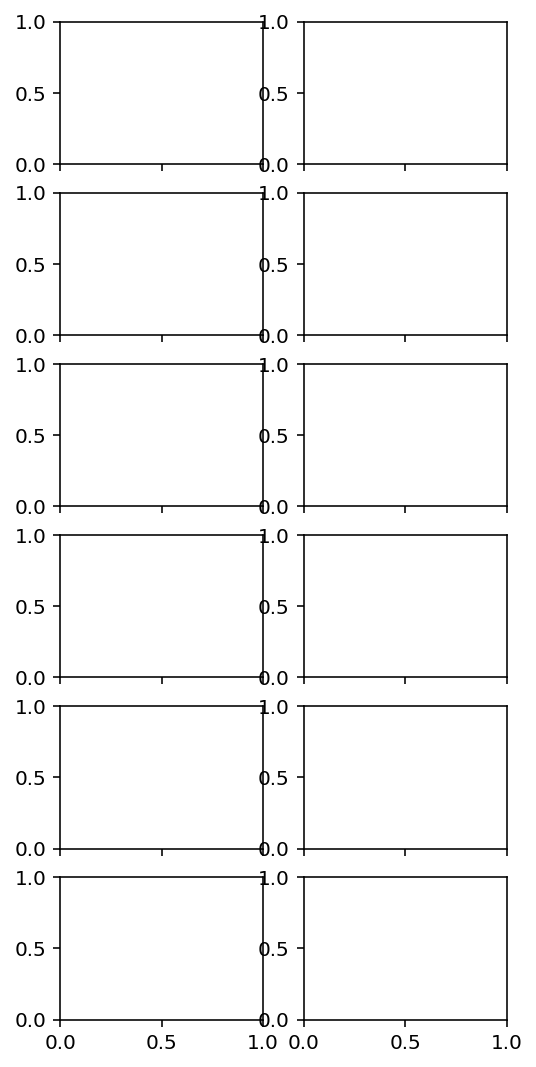

In [5]:
idxs = [3, 14, 15, 18, 22, 33]
def expGrowth(x, a, b, c):
    return growth(x, a, b, c, form="exp")

def linGrowth(x, a, b, c):
    return growth(x, a, b, c, form="linear")

fig, ax = plt.subplots(len(idxs), 2, dpi=144, figsize=(4, 1.5*len(idxs)), sharey=False, sharex=True)

σ = 2.0
for didx, datafile in enumerate(tqdm(list(np.array(acsfiles)[idxs]))):

    # get times and interp times
    with h5py.File(datafile, "r") as d:
        t = np.array([int(k) for k in list(d.keys())])
    t_interp = np.linspace(t[0], t[-1], 101)
    
    ϕW = []
    ϕB = []
    for year in t:
        w, b, xx, yy = get_data(datafile, year=year, region="all", norm=False)
        w_border, _, _, _ = get_data(datafile, year=year, region="all", norm=False)
        ϕW.append(w)
        ϕB.append(b)

    # white demographic data
    ϕW = np.asarray(ϕW)
    ϕW_smooth = ndimage.gaussian_filter(np.nan_to_num(ϕW),
                                        σ, axes=[1, 2])
    cubicW = interpolate.interp1d(t, ϕW_smooth, axis=0, kind="cubic")
    ϕW_smooth_interp = cubicW(t_interp)
    ϕW_smooth_interp[:, np.any(np.isnan(ϕW), axis=0)] = np.nan
    # ϕWs.append(ϕW_smooth_interp)

    # black demographic data
    ϕB = np.asarray(ϕB)
    ϕB_smooth = ndimage.gaussian_filter(np.nan_to_num(ϕB),
                                        σ, axes=[1, 2])
    cubicB = interpolate.interp1d(t, ϕB_smooth, axis=0, kind="cubic")
    ϕB_smooth_interp = cubicB(t_interp)
    ϕB_smooth_interp[:, np.any(np.isnan(ϕB), axis=0)] = np.nan
    # ϕBs.append(ϕB_smooth_interp)
    
    try:
        poptW, pcovW = optimize.curve_fit(linGrowth, t_interp,
                                          np.log(np.nansum(ϕW_smooth_interp, axis=(1, 2))),
                                          p0=[1e-3, 1e-6, 0],
                                          maxfev=int(1e5))
        poptB, pcovB = optimize.curve_fit(linGrowth, t_interp,
                                          np.log(np.nansum(ϕB_smooth_interp, axis=(1, 2))),
                                          p0=[1e-3, 1e-6, 0],
                                          maxfev=int(1e5))
    except Exception as e:
        print(e)

    ax[didx, 0].plot(t, np.nansum(ϕW_smooth, axis=(1, 2)),
                   "C0", zorder=-1, alpha=0.3)
    ax[didx, 0].plot(t, expGrowth(t, *poptW),
                         color="C0", ls="--",
                         label="\n".join([f"{coeff} = {val:0.2g}" for coeff, val in zip(["a", "b", "c"], poptW)]))
    
    ax[didx, 1].plot(t, np.nansum(ϕB_smooth, axis=(1, 2)),
                   "C3", zorder=-1, alpha=0.3)
    ax[didx, 1].plot(t, expGrowth(t, *poptB),
                         color="C3", ls="--",
                         label="\n".join([f"{coeff} = {val:0.2g}" for coeff, val in zip(["a", "b", "c"], poptB)]))
    
    ax[didx, 0].set(ylabel=datafile.split("/")[-1][:-5])
    

for a in ax.ravel():
    a.set_box_aspect(1)
    a.set(xticks=[2010, 2015, 2020])
    a.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
    a.legend(fontsize="x-small")

ax[0, 0].set(title="White pop.")
ax[0, 1].set(title="Black pop.")

fig.suptitle(r"$a e^{bx} + c$")
plt.tight_layout()
# fig.savefig("/project/vitelli/dsseara/schelling/data/2024-08-05_inferenceWithGrowth/2024-08-05_ACSGrowthFits_normFalse.pdf")

# Census data

  0%|          | 0/6 [00:00<?, ?it/s]


TypeError: expGrowth() missing 1 required positional argument: 'c'

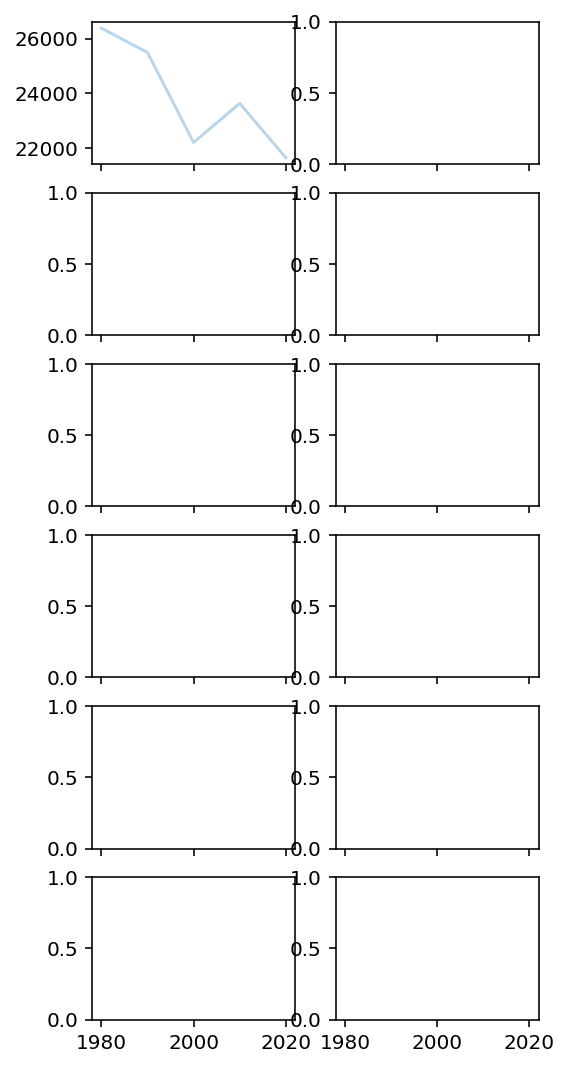

In [17]:
idxs = [3, 15, 16, 19, 23, 34]
# idxs = [15, 16]

fig, ax = plt.subplots(len(idxs), 2, dpi=144, figsize=(4, 1.5*len(idxs)), sharey=False, sharex=True)

σ = 2.0
for didx, datafile in enumerate(tqdm(list(np.array(censusfiles)[idxs]))):

    # get times and interp times
    with h5py.File(datafile, "r") as d:
        t = np.array([int(k) for k in list(d.keys())])
    t_interp = np.linspace(t[0], t[-1], 101)
    
    ϕW = []
    ϕB = []
    for year in t:
        w, b, xx, yy = get_data(datafile, year=year, region="all", norm=True)
        w_border, _, _, _ = get_data(datafile, year=year, region="all", norm=True)
        ϕW.append(w)
        ϕB.append(b)

    # white demographic data
    ϕW = np.asarray(ϕW)
    ϕW_smooth = ndimage.gaussian_filter(np.nan_to_num(ϕW),
                                        σ, axes=[1, 2])
    cubicW = interpolate.interp1d(t, ϕW_smooth, axis=0, kind="cubic")
    ϕW_smooth_interp = cubicW(t_interp)
    ϕW_smooth_interp[:, np.any(np.isnan(ϕW), axis=0)] = np.nan
    # ϕWs.append(ϕW_smooth)

    # black demographic data
    ϕB = np.asarray(ϕB)
    ϕB_smooth = ndimage.gaussian_filter(np.nan_to_num(ϕB),
                                        σ, axes=[1, 2])
    cubicB = interpolate.interp1d(t, ϕB_smooth, axis=0, kind="cubic")
    ϕB_smooth_interp = cubicB(t_interp)
    ϕB_smooth_interp[:, np.any(np.isnan(ϕB), axis=0)] = np.nan
    # ϕBs.append(ϕB_smooth)
    
    try:
        poptW, pcovW = optimize.curve_fit(linearGrowth, t_interp,
                                          np.log(np.nansum(ϕW_smooth_interp, axis=(1, 2))),
                                          p0=[1e-3, 1e-6],
                                          maxfev=int(1e5))
        poptB, pcovB = optimize.curve_fit(linearGrowth, t_interp,
                                          np.log(np.nansum(ϕB_smooth_interp, axis=(1, 2))),
                                          p0=[1e-3, 1e-6],
                                          maxfev=int(1e5))
    except Exception as e:
        print(e)

    ax[didx, 0].plot(t, np.nansum(ϕW_smooth, axis=(1, 2)),
                   "C0", zorder=-1, alpha=0.3)
    ax[didx, 0].plot(t, expGrowth(t, *poptW),
                         color="C0", ls="--",
                         label="\n".join([f"{coeff} = {val:0.2g}" for coeff, val in zip(["a", "b", "c"], poptW)]))
    
    ax[didx, 1].plot(t, np.nansum(ϕB_smooth, axis=(1, 2)),
                   "C3", zorder=-1, alpha=0.3)
    ax[didx, 1].plot(t, expGrowth(t, *poptB),
                         color="C3", ls="--",
                         label="\n".join([f"{coeff} = {val:0.2g}" for coeff, val in zip(["a", "b", "c"], poptB)]))
    
    ax[didx, 0].set(ylabel=datafile.split("/")[-1][:-5])
    

for a in ax.ravel():
    a.set_box_aspect(1)
    a.set(xticks=[t.min(), t.mean(), t.max()])
    a.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
    a.legend(fontsize="x-small")

ax[0, 0].set(title="White pop.")
ax[0, 1].set(title="Black pop.")

fig.suptitle(r"$a e^{bx} + c$")
plt.tight_layout()
# fig.savefig("/project/vitelli/dsseara/schelling/data/2024-08-05_inferenceWithGrowth/2024-08-05_CensusGrowthFits_normTrue.pdf")